### The neural network version for bank marketing

In [88]:
import pandas as pd

import matplotlib as plt
from keras import Sequential, layers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer


bank_data = pd.read_csv("../data/bank-full.csv", delimiter=";")

y_col = "y"

X = bank_data.drop([y_col],axis=1)

y = bank_data[y_col]

In [89]:
# Manually encode target data
label_encoder = LabelEncoder()
oh_encoder = OneHotEncoder()

X_train, X_valid, y_train, y_valid = train_test_split(X,y, train_size=0.8,test_size=0.2)

# encode y values
y_train = label_encoder.fit_transform(y_train) # pyright: ignore[reportCallIssue, reportArgumentType]
y_valid = label_encoder.transform(y_valid)

# non-numerical columns
categorical_cols = [col for col in X_train.columns if (X_train[col].dtype == "object") ]

# numerical columns
numerical_cols = [col for col in X_train.columns if X_train[col].dtype in ['int64', 'float64']]

preprocessor = make_column_transformer(
    (StandardScaler(), numerical_cols),
    (OneHotEncoder(), categorical_cols),
)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

input_shape = [X_train.shape[1]]


In [90]:
layers = [
    layers.BatchNormalization(input_shape=input_shape),

    layers.Dense(128,activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.3),


    layers.Dense(64,activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.3),
    
    # sigmoid for classification output
    layers.Dense(1,activation='sigmoid')
]

f:\projects\modelz\.venv\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [91]:
model = Sequential(layers=layers)

early_stopping = callbacks.EarlyStopping(patience=5,
                                      min_delta=0.001,restore_best_weights=True)
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

In [92]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid,y_valid),
    callbacks=[early_stopping],
    batch_size=64,
    epochs=50,
)

Epoch 1/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - binary_accuracy: 0.8442 - loss: 0.3740 - val_binary_accuracy: 0.9017 - val_loss: 0.2376
Epoch 2/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - binary_accuracy: 0.8947 - loss: 0.2506 - val_binary_accuracy: 0.8993 - val_loss: 0.2258
Epoch 3/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - binary_accuracy: 0.8997 - loss: 0.2319 - val_binary_accuracy: 0.9016 - val_loss: 0.2164
Epoch 4/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - binary_accuracy: 0.9020 - loss: 0.2233 - val_binary_accuracy: 0.9030 - val_loss: 0.2142
Epoch 5/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - binary_accuracy: 0.9005 - loss: 0.2170 - val_binary_accuracy: 0.9017 - val_loss: 0.2128
Epoch 6/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - binary_accuracy: 0.9037 - loss: 0.2157 - val_binary_accuracy: 0.9007 - val_loss: 0.2122
Epoch 7/50
566/566 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - binary_accuracy: 0.9035 - loss: 0.2112 - val_binary_accuracy: 0.9017 - val_loss: 0.2114
Epoch 

<Axes: >

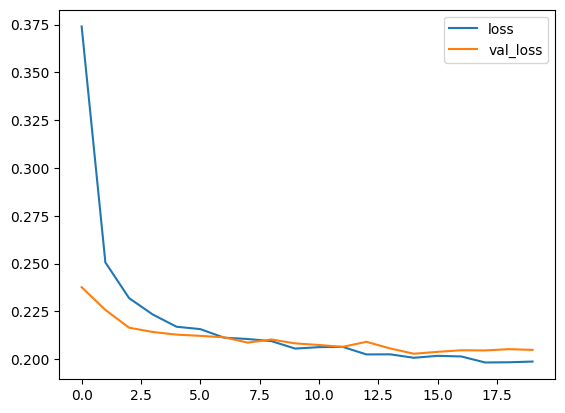

In [93]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
